<a href="https://colab.research.google.com/github/kalebmes/ML-and-DL-projects/blob/main/Chest%20X_ray%20classification/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [94]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia --unzip --force

 99% 2.28G/2.29G [00:17<00:00, 122MB/s]
100% 2.29G/2.29G [00:17<00:00, 137MB/s]


In [95]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import torchvision.datasets as dset
import torchvision.transforms as T

In [96]:
data_path = os.path.join('/content', 'chest_xray', 'chest_xray')
train_path = os.path.join(data_path, 'train')
validation_path = os.path.join(data_path, 'val')
test_path = os.path.join(data_path, 'test')

In [97]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
train_augs = T.Compose([T.RandomHorizontalFlip(p=0.5), 
                        T.RandomRotation(degrees=(-20, +20)), 
                        T.Resize((32,32)),
                        T.ToTensor()])

valid_augs = T.Compose([T.Resize((32,32)), T.ToTensor()])

In [98]:
trainset = ImageFolder(train_path, transform=train_augs)
validset = ImageFolder(validation_path, transform=valid_augs)
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 5216
Total no. of examples in validset : 16


In [99]:
print(trainset.class_to_idx)

{'NORMAL': 0, 'PNEUMONIA': 1}


chosen index:  4895


Text(0.5, 1.0, '1')

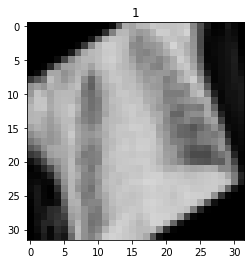

In [100]:
#we can view some images and their labels
import matplotlib.pyplot as plt
idx = np.random.randint(low=0, high=len(trainset)-1)
print('chosen index: ', idx)
image, label = trainset[idx] # the image has format of h, w, c -> so it have to be reshaped
plt.imshow(image.permute(1, 2, 0))
plt.title(label)

In [101]:
lr = 1e-3
batch_size = 8
epochs = 30

#device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device} device')

using cuda device


In [102]:
#now let's read the dataset using pytorch's dataloader
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, )
validloader = DataLoader(validset, batch_size=batch_size)
print('total batches in trainloader: ', len(trainloader), 'and validloader: ', len(validloader))

total batches in trainloader:  652 and validloader:  2


In [115]:
C, H, W = 3, 32, 32
num_classes = 1
channel_1, channel_2, channel_3, channel_4, channel_5, channel_6 = [32, 64, 128, 128,256, 256]
learning_rate = 1e-2
momentum = 0.5
class MyConvolution(nn.Module):
  def __init__(self, in_channel=3, channel_1=32, channel_2=64, channel_3=128, channel_4=128, channel_5=256, channel_6=256, num_classes=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=channel_1, kernel_size=(3,3), stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.conv2 = nn.Conv2d(in_channels=channel_1, out_channels=channel_2, kernel_size=(3,3), padding=1, stride=1)
    self.conv3 = nn.Conv2d(in_channels=channel_2, out_channels=channel_3, kernel_size=(3,3), padding=1, stride=1)
    self.conv4 = nn.Conv2d(in_channels=channel_3, out_channels=channel_4, kernel_size=(3,3), padding=1, stride=1)
    self.conv5 = nn.Conv2d(in_channels=channel_4, out_channels=channel_5, kernel_size=(3,3), padding=1, stride=1)
    self.conv6 = nn.Conv2d(in_channels=channel_5, out_channels=channel_6, kernel_size=(3,3), padding=1, stride=1)
    self.fc1 = nn.Linear(4*4*channel_6, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, num_classes)
    #now initializing our parameters
    nn.init.kaiming_normal_(self.conv1.weight)
    nn.init.zeros_(self.conv1.bias)
    nn.init.kaiming_normal_(self.conv2.weight)
    nn.init.zeros_(self.conv2.bias)
    nn.init.kaiming_normal_(self.conv3.weight)
    nn.init.zeros_(self.conv3.bias)
    nn.init.kaiming_normal_(self.conv4.weight)
    nn.init.zeros_(self.conv4.bias)
    nn.init.kaiming_normal_(self.conv5.weight)
    nn.init.zeros_(self.conv5.bias)
    nn.init.kaiming_normal_(self.conv6.weight)
    nn.init.zeros_(self.conv6.bias)
    nn.init.kaiming_normal_(self.fc1.weight)
    nn.init.zeros_(self.fc1.bias)
    nn.init.kaiming_normal_(self.fc2.weight)
    nn.init.zeros_(self.fc2.bias)
    nn.init.kaiming_normal_(self.fc2.weight)
    nn.init.zeros_(self.fc2.bias)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.pool(x)
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.pool(x)
    x = F.relu(self.fc1(nn.Flatten()(x)))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
model = MyConvolution(C, channel_1, channel_2, channel_3, channel_4, channel_5, channel_6, num_classes)
model.to(device)

MyConvolution(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1, bias=True)
)

In [116]:
def binary_accuracy(y_pred, y_true):
  y_pred = torch.sigmoid(y_pred)
  y_pred[y_pred >= 0.5] = 1
  y_pred[y_pred < 0.5] = 0
  return torch.mean((y_pred == y_true).type(torch.FloatTensor))

In [117]:
from tqdm import tqdm

def train_model(model, dataloader, optimizer, current_epoch):

  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[TRAIN]' + str(current_epoch + 1) + "/" + str(epochs))

  for t, data in enumerate(tk):
    images, labels = data
    labels = labels.reshape(-1, 1).float()
    images, labels = images.to(device), labels.to(device)

    # logits, loss = model(images, labels)
    logits = model(images)
    loss = nn.BCEWithLogitsLoss()(logits, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += binary_accuracy(logits, labels)
    tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc / len(dataloader)

def eval_model(model, dataloader, current_epoch):

  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[VALID]' + str(current_epoch + 1) + "/" + str(epochs))

  for t, data in enumerate(tk):
    images, labels = data
    labels = labels.reshape(-1, 1).float()
    images, labels = images.to(device), labels.to(device)

    # logits, loss = model(images, labels)
    logits = model(images)
    loss = nn.BCEWithLogitsLoss()(logits, labels)

    total_loss += loss.item()
    total_acc += binary_accuracy(logits, labels)
    tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc / len(dataloader)

In [118]:
#now let's train the model
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=1e-2, nesterov=True)

In [119]:
for images, labels in trainset:
  break
print('images batch shape: ', images.shape)
print('labels batch shape', labels)

images batch shape:  torch.Size([3, 32, 32])
labels batch shape 0


In [120]:
best_valid_loss = np.Inf
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
for i in range(epochs):
  train_loss, train_acc = train_model(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_model(model, validloader, i)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  train_accuracies.append(train_acc)
  valid_accuracies.append(valid_acc)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-weights.pt')
    print('SAVED BEST WEIGHTS')
    best_valid_loss = valid_loss
print()
print()
print('accuracy on the training set: ', float(train_acc))
print('accuracy on the validation set: ', float(valid_acc))

EPOCH[VALID]1/30: 100%|██████████| 2/2 [00:00<00:00,  8.40it/s, loss=0.713, acc=0.75]


SAVED BEST WEIGHTS


EPOCH[VALID]2/30: 100%|██████████| 2/2 [00:00<00:00,  7.99it/s, loss=0.218, acc=0.938]


SAVED BEST WEIGHTS


EPOCH[VALID]16/30: 100%|██████████| 2/2 [00:00<00:00,  8.18it/s, loss=0.166, acc=0.938]


SAVED BEST WEIGHTS


EPOCH[VALID]30/30: 100%|██████████| 2/2 [00:00<00:00,  8.45it/s, loss=0.576, acc=0.812]



accuracy on the training set:  0.9758435487747192
accuracy on the validation set:  0.8125


In [121]:
def plot_the_loss_curve(epochs, training_losses, validation_losses):
  """Plot a curve of loss vs. epoch."""
  epochs = list(range(1, epochs + 1))
  plt.figure(figsize=(10, 5))
  plt.xlabel("Epoch")
  plt.ylabel("Cross Entropy losses")

  plt.plot(epochs[1:], training_losses[1:], label="Training Loss")
  plt.plot(epochs[1:], validation_losses[1:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_losses = training_losses[1:] + validation_losses[1:]
  highest_loss = max(merged_losses)
  lowest_loss = min(merged_losses)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
  plt.title('loss curve') 
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()

1.6616926060857666


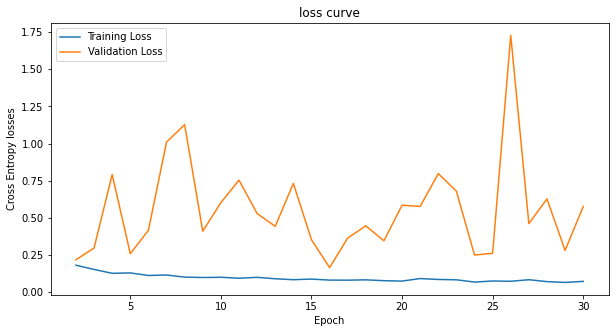

In [122]:
plot_the_loss_curve(epochs, train_losses, valid_losses)